_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Student name:  <span style='background: yellow'>*Aleksejs Timcenko, Ali Gholamzadeh* </span> 

# Coding Lab 3

- __Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
from __future__ import annotations


sns.set_style('ticks')

%matplotlib inline

# %load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2023-05-10 05:02:17CEST

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.8.0

sklearn: 0.0.post2

scipy     : 1.10.0
numpy     : 1.24.1
matplotlib: 3.6.3
seaborn   : 0.12.2
pandas    : 1.5.3

Watermark: 2.3.1



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium_orig = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes_orig = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium_orig = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes_orig = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)

In [4]:
ogb_calcium_orig.shape, ogb_spikes_orig.shape, gcamp_calcium_orig.shape, gcamp_spikes_orig.shape

((71986, 11), (71986, 11), (23973, 37), (23973, 37))

In [5]:
ogb_calcium_orig.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.234928,0.689186,2.578560,0.636770,-0.015140,0.819771,2.442105,0.391310,0.223523,1.557675,0.625052
1,-0.182441,0.869132,2.868601,0.596164,0.022464,0.831411,2.930201,0.490213,0.116095,1.628054,0.638718
2,-0.049257,0.949273,2.784989,0.711875,0.040028,0.877191,3.065872,0.610873,0.154437,1.479382,0.552809
3,-0.032876,0.848802,2.430735,0.940943,0.038616,0.975941,3.051014,0.714453,0.335288,1.302766,0.420998
4,-0.125313,0.665088,2.064211,1.168007,0.014035,1.156689,2.967063,0.737085,0.550485,1.234470,0.367595


### Resample data

In [6]:
def downsample_counts(counts, fs_original, fs_downsampled):
    """
    Downsamples the spike counts by the factor q = int(fs_original / fs_downsampled) using rebinning method
    
    Input:
        counts: np.ndarray, (n_times, n_channels)
            Counts time series
            
        fs_original: int
            Sampling rate of the original time series
            
        fs_downsampled: int
            Desired sampling rate
            
    Output:
        counts_ds: np.ndarray, (n_times_ds, n_channels)
            Downsampled counts time series
            
    n_times_ds = np.ceil(n_times / q)
    
    """
    # Compute the duration of each time bin in the original time series
    dt_original = 1.0 / fs_original
    # Compute the duration of each time bin in the downsampled time series
    dt_downsampled = 1.0 / fs_downsampled
    # Compute the length of the input time series
    n_bins, n_channels = counts.shape
    # Compute the new length of the downsampled time series
    n_bins_ds = int(np.ceil(n_bins * dt_original * fs_downsampled))
    # Create a new array to store the downsampled time series data
    counts_ds = np.zeros((n_bins_ds, n_channels), dtype=int)
    # Compute the count rates in each time window for each channel
    count_rates = counts.astype(float) / dt_original
    count_rates = np.nan_to_num(count_rates, nan=0.0)
    q = int(fs_original / fs_downsampled)
    # Downsample each channel separately
    for i_chan in range(n_channels):
        # Compute the downsampled time series data by averaging count rates
        for i_time in range(n_bins_ds):
            t_start = i_time * q
            t_end = min((i_time + 1) * q, counts.shape[0])
            counts_ds[i_time, i_chan] = np.round(np.nanmean(count_rates[t_start:t_end, i_chan]))
    counts_ds = counts_ds * dt_downsampled
    return counts_ds

In [7]:
%%time
fs_orig = 100
fs = 25
q = int(fs_orig / fs)
filter_order = 4

# get times for downsampled signals for plotting. Test downsampling.
times_orig = np.arange(ogb_calcium_orig.shape[0]) / fs_orig

# Actually resample all the data. 
# Note that numpy arrays will be the result of this opetation

ogb_calcium = signal.decimate(ogb_calcium_orig.to_numpy(), q, n=filter_order, axis=0)
ogb_spikes = downsample_counts(ogb_spikes_orig.to_numpy(), fs_orig, fs)
gcamp_calcium = signal.decimate(gcamp_calcium_orig.to_numpy(), q, n=filter_order, axis=0)
gcamp_spikes = downsample_counts(gcamp_spikes_orig.to_numpy(), fs_orig, fs)

times = np.arange(ogb_calcium.shape[0]) / fs

print(ogb_calcium_orig.shape)
print(ogb_calcium.shape)

(71986, 11)
(17997, 11)
CPU times: user 9.75 s, sys: 727 ms, total: 10.5 s
Wall time: 9.82 s


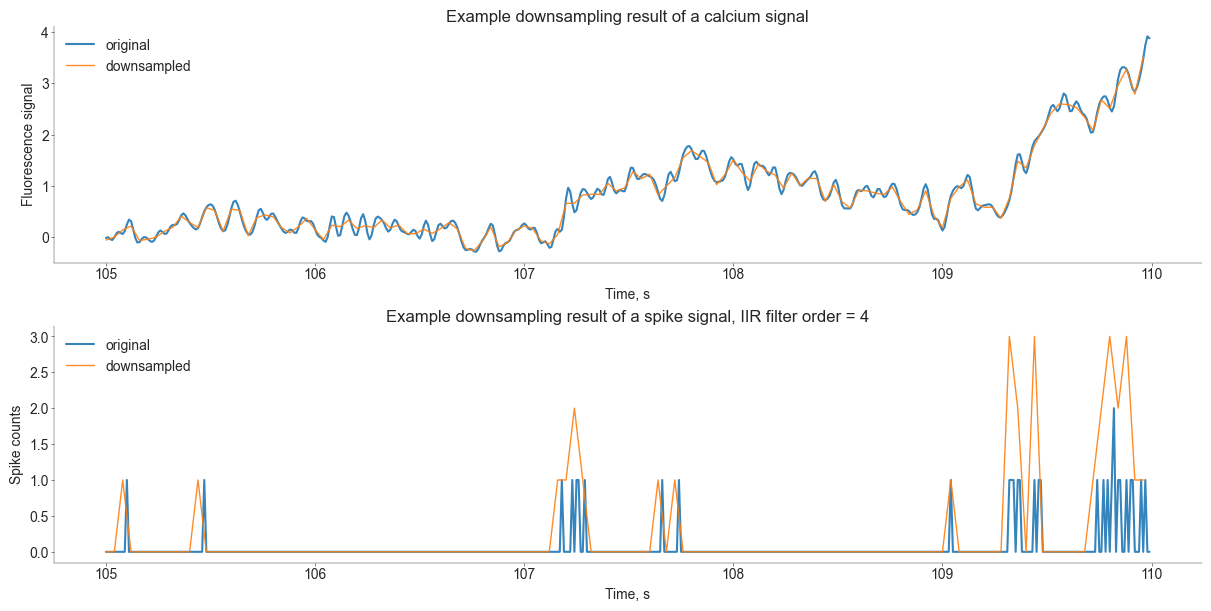

In [8]:
t_min, t_max = 105, 110
i_neuron = 4


plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)

plt.plot(
    times_orig[int(t_min * fs_orig):int(t_max * fs_orig)], 
    ogb_calcium_orig.to_numpy()[int(t_min * fs_orig):int(t_max * fs_orig), i_neuron], 
    linewidth=1.5,
    label='original', 
    alpha=0.9)

plt.plot(
    times[int(t_min * fs):int(t_max * fs)], 
    ogb_calcium[int(t_min * fs):int(t_max * fs), i_neuron], 
    linewidth=1, 
    label='downsampled', 
    alpha=0.9)


plt.ylabel("Fluorescence signal")
plt.xlabel("Time, s")
plt.title("Example downsampling result of a calcium signal")
plt.legend()

plt.subplot(2, 1, 2)

plt.plot(
    times_orig[int(t_min * fs_orig):int(t_max * fs_orig)], 
    ogb_spikes_orig.to_numpy()[int(t_min * fs_orig):int(t_max * fs_orig), i_neuron], 
    linewidth=1.5,
    label='original', 
    alpha=0.9)

plt.plot(
    times[int(t_min * fs):int(t_max * fs)], 
    ogb_spikes[int(t_min * fs):int(t_max * fs), i_neuron], 
    linewidth=1, 
    label='downsampled', 
    alpha=0.9)


plt.ylabel("Spike counts")
plt.xlabel("Time, s")
plt.title(f"Example downsampling result of a spike signal, IIR filter order = {filter_order}")
plt.legend()
plt.show()

## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

In [9]:
# test whether scipy.decimate works better for gcamp

gcamp_spikes_decim = signal.decimate(gcamp_spikes_orig.to_numpy(), q, n=filter_order, axis=0)

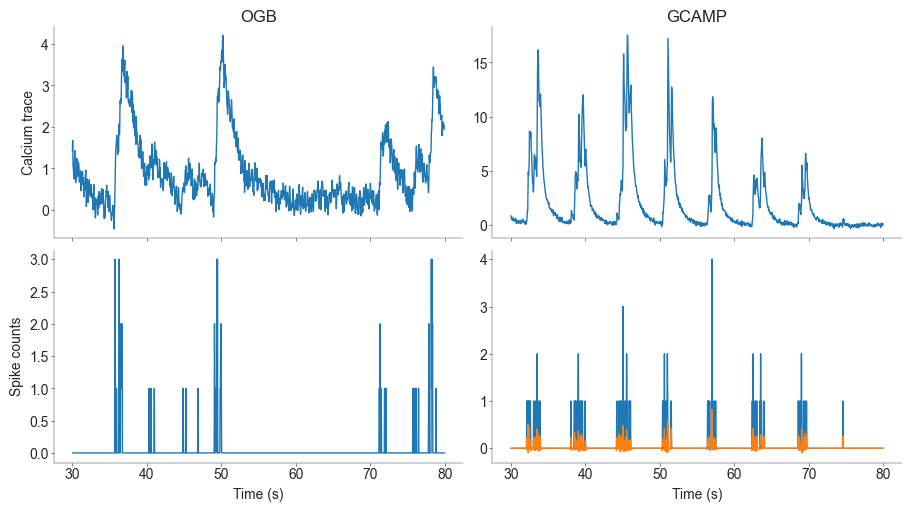

In [11]:
# ----------------------------
# Plot raw calcium data (1 pt)
# ----------------------------

# --------------------------
# Plot raw spike data (1 pt)
# --------------------------

i_cell_ogb = 4
i_cell_gcamp = 0

t0, t1 = 30, 80 # in sec
t_slice = slice(int(t0 * fs), int(t1 * fs))

fig, axes = plt.subplots(
    2, 2, figsize=(9, 5), layout="constrained"
)


# plot raw ogb data

ax = axes[0, 0]
ax.plot(times[t_slice], ogb_calcium[t_slice, i_cell_ogb])
ax.set_title("OGB")
ax.set_xticklabels('')
ax.set_ylabel("Calcium trace")

ax = axes[1, 0]
ax.plot(times[t_slice], ogb_spikes[t_slice, i_cell_ogb])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Spike counts")


# plot raw gcamp data

ax = axes[0, 1]
ax.plot(times[t_slice], gcamp_calcium[t_slice, i_cell_gcamp])
ax.set_title("GCAMP")
ax.set_xticklabels('')

ax = axes[1, 1]
ax.plot(times[t_slice], gcamp_spikes[t_slice, i_cell_gcamp])
ax.plot(times[t_slice], gcamp_spikes_decim[t_slice, i_cell_gcamp])
ax.set_xlabel("Time (s)")
plt.show()

### Testing denoising of the calcium data


#### Low-pass filtering

Text(0.5, 1.0, 'Applying low-pass filter on the data')

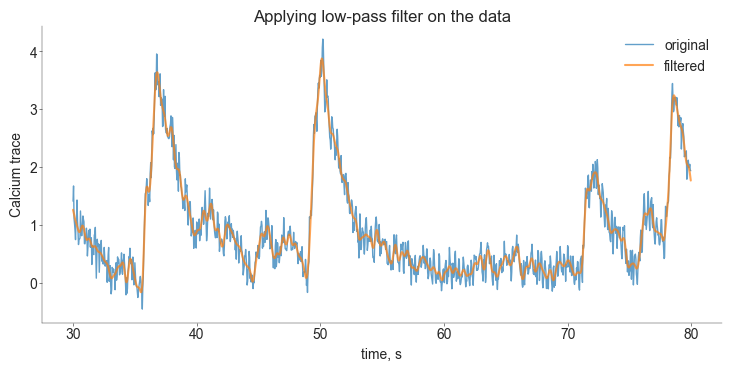

In [18]:
from mne.filter import filter_data
mne.set_log_level(verbose="ERROR")
ogb_calcium_filtered = filter_data(ogb_calcium.T, fs, 0, 1).T

plt.plot(times[t_slice], ogb_calcium[t_slice, i_cell_ogb], alpha=0.7, label='original')
plt.plot(times[t_slice], ogb_calcium_filtered[t_slice, i_cell_ogb], alpha=0.7, label='filtered', linewidth=1.5)
plt.legend()
plt.xlabel("time, s")
plt.ylabel("Calcium trace")
plt.title("Applying low-pass filter on the data")

#### Sliding average

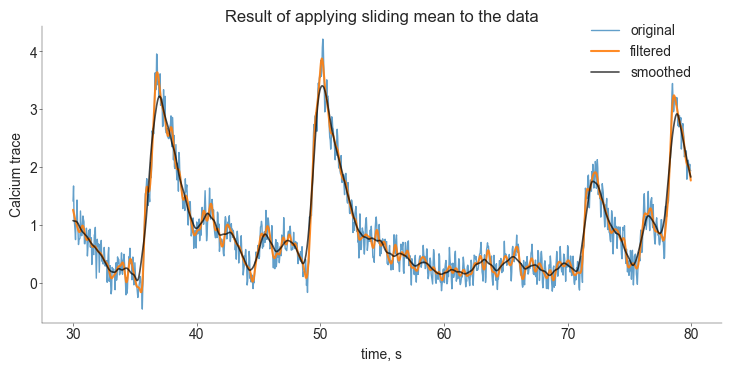

In [19]:
n_mean = 25
kernel = np.ones(n_mean) / n_mean
ogb_calcium_convolved = np.zeros_like(ogb_calcium_filtered)
for i_chan in range(ogb_calcium_filtered.shape[1]):
    ogb_calcium_convolved[:, i_chan] = signal.convolve(ogb_calcium_filtered[:, i_chan], kernel, mode="same")
    
    
plt.plot(times[t_slice], ogb_calcium[t_slice, i_cell_ogb], alpha=0.7, label='original')
plt.plot(times[t_slice], ogb_calcium_filtered[t_slice, i_cell_ogb], alpha=0.9, label='filtered', linewidth=1.5)
plt.plot(times[t_slice], ogb_calcium_convolved[t_slice, i_cell_ogb], alpha=0.7, color='black', label='smoothed', linewidth=1.2)
plt.legend(loc=(0.8, 0.8))
plt.xlabel("time, s")
plt.ylabel("Calcium trace")
plt.title("Result of applying sliding mean to the data")
plt.show()

In [20]:
def denoise_calcium_signal(ca, fs=25, n_conv_kernel=25):
    ca_filt = filter_data(ca.T, fs, 0, 1).T
    n_mean  = n_conv_kernel
    kernel  = np.ones(n_mean) / n_mean
    ca_conv = np.zeros_like(ca)
    for i_chan in range(ca.shape[1]):
        ca_conv[:, i_chan] = signal.convolve(ca_filt[:, i_chan], kernel, mode="same")
    return ca_conv   

In [21]:
ogb_calcium_denoised = denoise_calcium_signal(ogb_calcium)
gcamp_calcium_denoised = denoise_calcium_signal(gcamp_calcium)

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this.

*Grading: 3 pts*


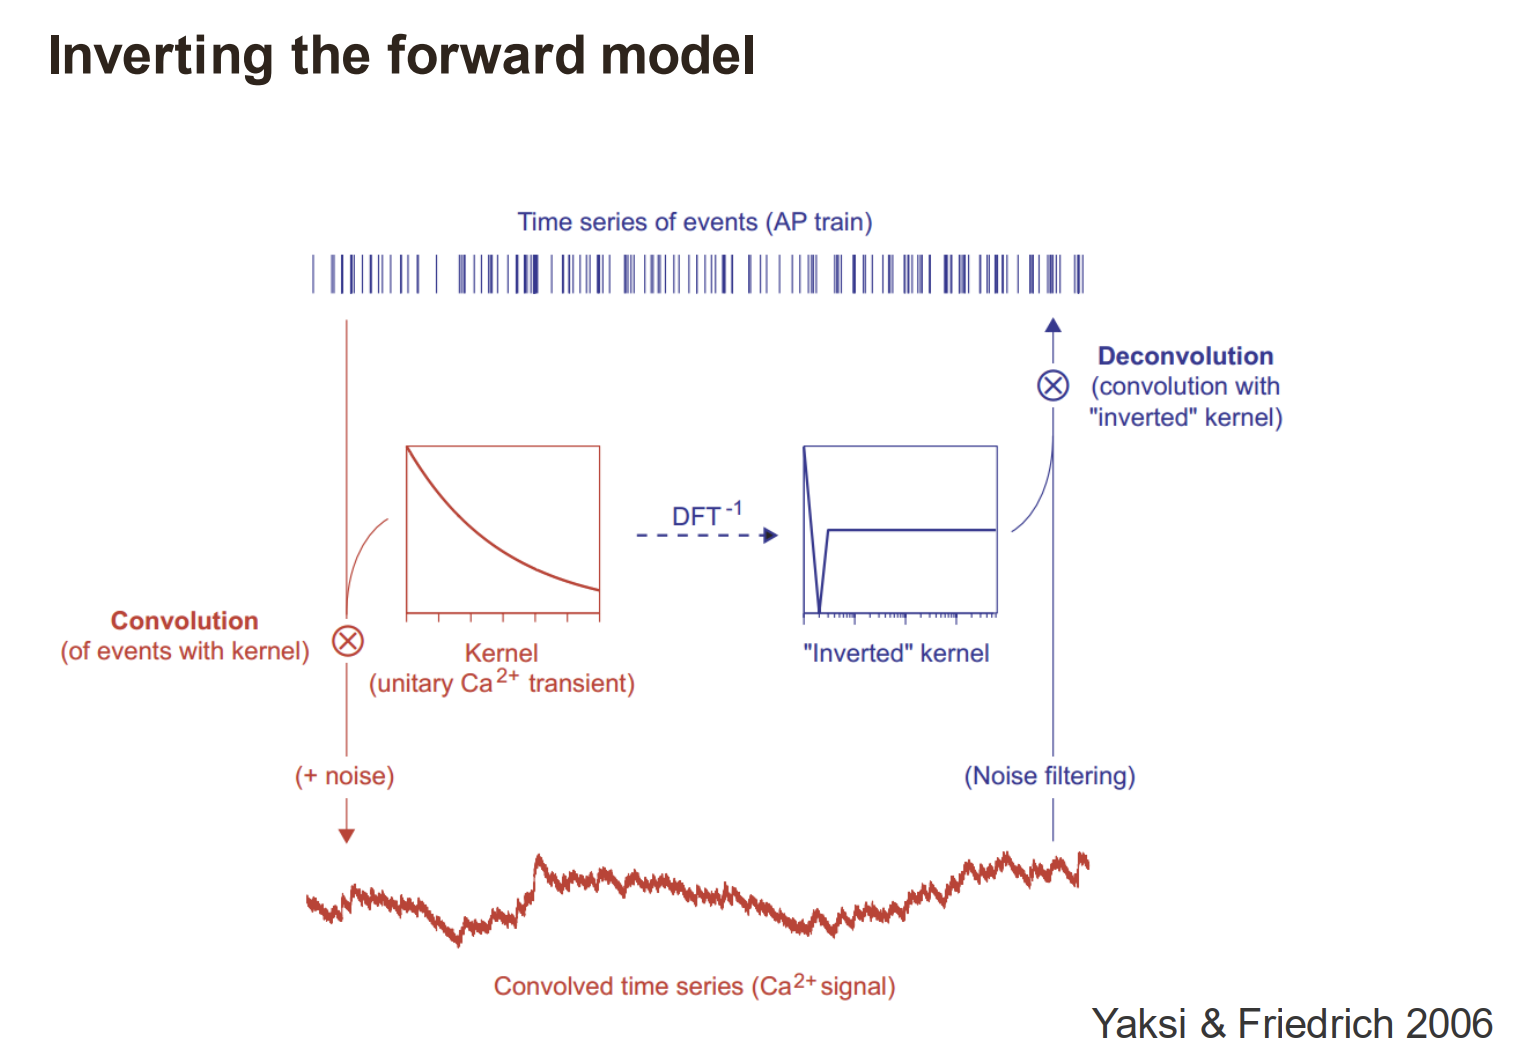

In [22]:
def deconv_ca(ca, tau, dt):
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # insert your code here
    
    # tau indicates the decrease of the initial value in e-times. Let's set the t to 3
    kernel_length = int(4 * tau / dt)
    kernel_times  = np.arange(kernel_length) * dt
    kernel        = np.exp(-kernel_times / tau)

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------
    
    sp_hat, _ = signal.deconvolve(ca, kernel)
    sp_hat    = np.maximum(0, sp_hat) # applying ReLU

    return sp_hat

50
10


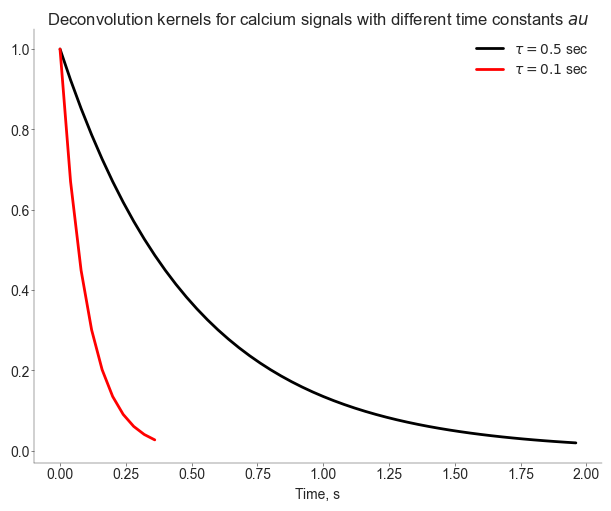

In [24]:
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------

tau_list = tau_ogb, tau_gcamp = [0.5, 0.1]
dt = 1 / fs
colors = iter(["black", "red"])

for tau in tau_list:
    label = f"$\\tau={{{tau}}}$ sec"
    kernel_length = int(4 * tau / dt)
    print(kernel_length)
    kernel_times = np.arange(kernel_length) * dt
    kernel = np.exp(-kernel_times / tau)
    ax.plot(kernel_times, kernel, label=label, color=next(colors), linewidth=2)
ax.legend()
ax.set_title("Deconvolution kernels for calcium signals with different time constants $\tau$")
ax.set_xlabel("Time, s");
plt.show()

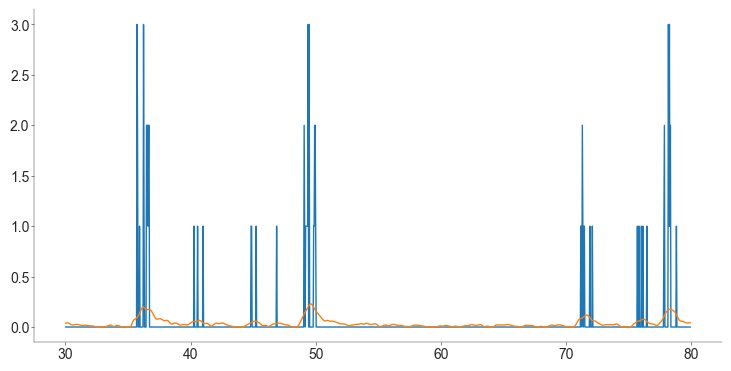

In [26]:
sp_hat_ogb = deconv_ca(ogb_calcium_denoised[:, i_cell_ogb], tau=tau_ogb + 0.5, dt=1/fs)

plt.plot(times[t_slice], ogb_spikes[t_slice, i_cell_ogb])
plt.plot(times[t_slice], sp_hat_ogb[t_slice])
plt.show()

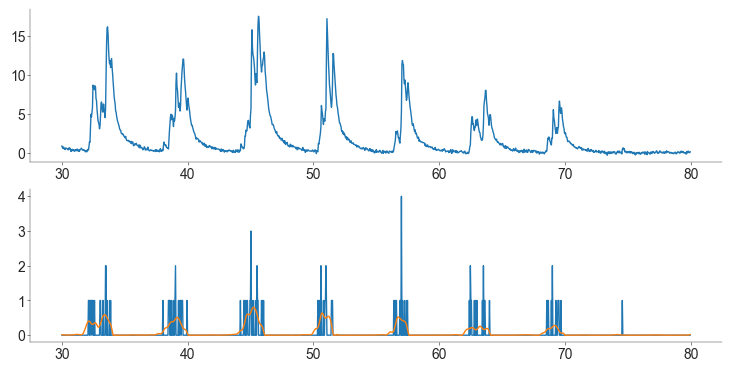

In [27]:
sp_hat_gcamp = deconv_ca(gcamp_calcium_denoised[:, i_cell_gcamp], tau=tau_gcamp + 1, dt=1/fs)

plt.subplot(2, 1, 1)
plt.plot(times[t_slice], gcamp_calcium[t_slice, i_cell_gcamp])
plt.subplot(2, 1, 2)
plt.plot(times[t_slice], gcamp_spikes[t_slice, i_cell_gcamp])
plt.plot(times[t_slice], sp_hat_gcamp[t_slice])
plt.show()

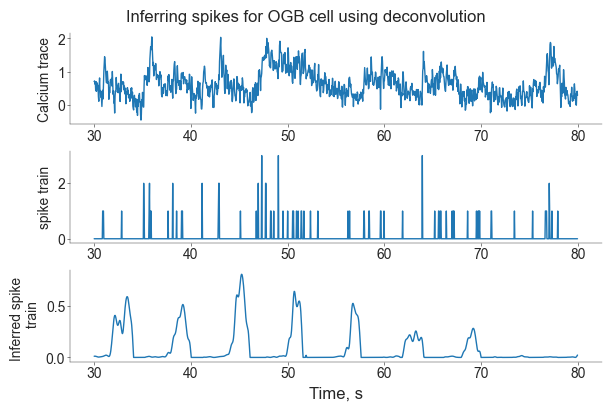

In [100]:
# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell
fig.suptitle("Inferring spikes for OGB cell using deconvolution")
# OGB Cell
axs[0].plot(times[t_slice], ogb_calcium[t_slice, i_cell_gcamp])
axs[0].set_ylabel("Calcium trace")

axs[1].plot(times[t_slice], ogb_spikes[t_slice, i_cell_gcamp])
axs[1].set_ylabel("spike train")

axs[2].plot(times[t_slice] ,sp_hat_gcamp[t_slice])
axs[2].set_ylabel("Inferred spike \n train")
axs[2].set_xlabel("Time, s", fontsize = 12)

plt.show()


## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [28]:
# run this cell to download the oopsi.py file if you haven't already mannually downloaded it
# and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py

zsh:1: command not found: wget


In [29]:
import oopsi

In [48]:
# --------------------------------------------------------------
# Apply one of the advanced algorithms on the OGB Cell (0.5 pts)
# --------------------------------------------------------------
oopsi_ogb_fast, Cz = oopsi.fast(ogb_calcium[:, i_cell_ogb], dt=1/fs, iter_max=10)

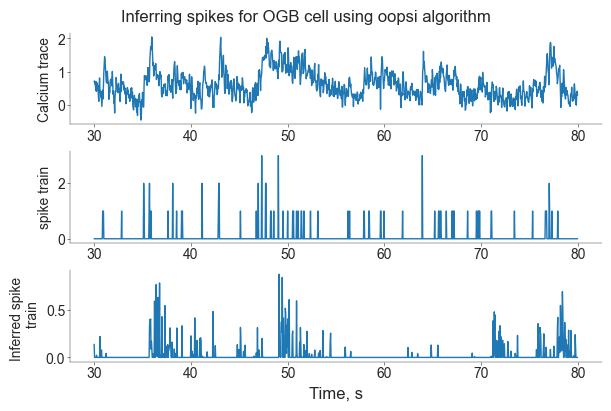

In [61]:
# -------------------------------------------
# Plot the results for the OGB Cell (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

fig.suptitle("Inferring spikes for OGB cell using oopsi algorithm")
# OGB Cell
axs[0].plot(times[t_slice], ogb_calcium[t_slice, i_cell_gcamp])
axs[0].set_ylabel("Calcium trace")

axs[1].plot(times[t_slice], ogb_spikes[t_slice, i_cell_gcamp])
axs[1].set_ylabel("spike train")

axs[2].plot(times[t_slice] ,oopsi_ogb_fast[t_slice])
axs[2].set_ylabel("Inferred spike \n train")
axs[2].set_xlabel("Time, s", fontsize = 12)

plt.show()

In [50]:
# ----------------------------------------------------------------
# Apply one of the advanced algorithms on the GCamP Cell (0.5 pts)
# ----------------------------------------------------------------
oopsi_gcamp_fast, Cz = oopsi.fast(gcamp_calcium[:, i_cell_ogb], dt=1/fs, iter_max=10)

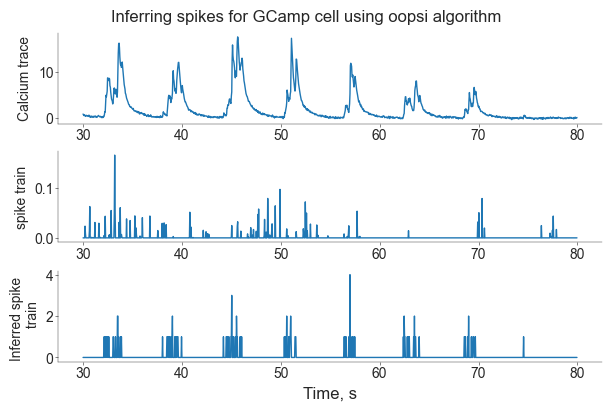

In [63]:
# ---------------------------------------------
# Plot the results for the GCamp Cell (0.5 pts)
# ---------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)
fig.suptitle("Inferring spikes for GCamp cell using oopsi algorithm")

axs[0].plot(times[t_slice], gcamp_calcium[t_slice, i_cell_gcamp])
axs[0].set_ylabel("Calcium trace")


axs[1].plot(times[t_slice] ,oopsi_gcamp_fast[t_slice])
axs[1].set_ylabel("spike train")

axs[2].plot(times[t_slice], gcamp_spikes[t_slice, i_cell_gcamp])
axs[2].set_ylabel("Inferred spike \n train")
axs[2].set_xlabel("Time, s", fontsize = 12)

plt.show()

# GCamP Cell

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [114]:
# -------------------------------------------------
# Create dataframe for OGB Cell as described (1 pt)
# -------------------------------------------------
algo = []
c = []
indicator = []
n_ogb_cells = ogb_calcium.shape[1]
for i in range(n_ogb_cells):
    if i ==2 or i == 3 or i == 7 or i == 9:
        continue
    orig_ogb_spike = ogb_spikes[:, i]
    
    indicator.append("OGB")
    algo.append("deconvolution")
    sp_hat_ogb = deconv_ca(ogb_calcium_denoised[:, i], tau=tau_ogb + 0.5, dt=1/fs)
    c.append(np.corrcoef(orig_ogb_spike[:len(sp_hat_ogb)], sp_hat_ogb)[0,1])
    
    indicator.append("OGB")
    algo.append("oopsi")
    oopsi_ogb_fast, Cz = oopsi.fast(ogb_calcium[:, i], dt=1/fs, iter_max=6)
    c.append(np.corrcoef(orig_ogb_spike, oopsi_ogb_fast)[0,1])


0
1
4
5
6
8
10


Create OGB dataframe

In [115]:
df_ogb = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_ogb.head()

,algorithm,correlation,indicator
0,deconvolution,0.178192,OGB
1,oopsi,0.345641,OGB
2,deconvolution,0.149207,OGB
3,oopsi,0.171029,OGB
4,deconvolution,0.355327,OGB


Evaluate on GCamp data

In [102]:
gcamp_calcium_denoised[:,10]

array([nan, nan, nan, ..., nan, nan, nan])

In [116]:
# ---------------------------------------------------
# Create dataframe for GCamP Cell as described (1 pt)
# ---------------------------------------------------
algo = []
c = []
indicator = []
n_ogb_cells = ogb_calcium.shape[1]
for i in range(n_ogb_cells):
    if i == 10:
        continue
    orig_gcamp_spike = gcamp_spikes[:, i]
    
    indicator.append("GCamP")
    algo.append("deconvolution")
    sp_hat_gcamp = deconv_ca(gcamp_calcium_denoised[:, i], tau=tau_ogb + 0.5, dt=1/fs)
    c.append(np.corrcoef(orig_gcamp_spike[:len(sp_hat_gcamp)], sp_hat_gcamp)[0,1])
    
    indicator.append("GCamP")
    algo.append("oopsi")
    oopsi_gcamp_fast, Cz = oopsi.fast(gcamp_calcium[:, i], dt=1/fs, iter_max=6)
    c.append(np.corrcoef(orig_gcamp_spike, oopsi_gcamp_fast)[0,1])


0
1
2
3
4
5
6
7
8
9


Create GCamp dataframe

In [117]:
df_gcamp = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_gcamp.head()

,algorithm,correlation,indicator
0,deconvolution,0.436075,GCamP
1,oopsi,0.327024,GCamP
2,deconvolution,0.231930,GCamP
3,oopsi,0.385407,GCamP
4,deconvolution,0.368307,GCamP


Combine both dataframes and plot

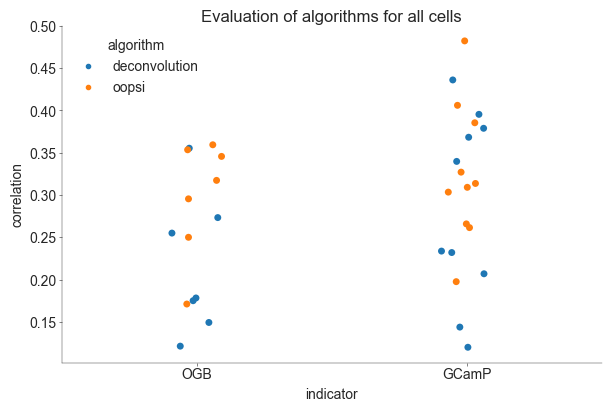

In [133]:
# ---------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described (1 pt)
# hint: you can seperate the algorithms by color
# ---------------------------------------------------------------------------
plt.figure(figsize=(6, 4))
df = pd.concat([df_ogb, df_gcamp], axis=0)
sns.stripplot(data=df, x = "indicator", y ="correlation", hue = "algorithm", size= 10)
plt.title("Evaluation of algorithms for all cells")
plt.show()

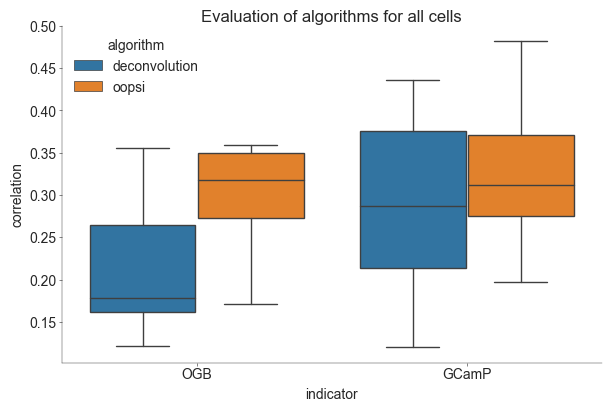

In [134]:
plt.figure(figsize=(6, 4))
plt.title("Evaluation of algorithms for all cells")
sns.boxplot(data=df, x="indicator", y="correlation", hue="algorithm")
plt.show()